In [206]:
import os
import numpy as np
import pandas as pd

import librosa
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
import pandas as pd

file_path = '/content/drive/MyDrive/extracted_audios/audio_index.csv'
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,speaker_id,speaker_folder,subfolder_id,audio_id,path
0,Steltek,Steltek-20090509-twd,wav,a0527,/content/drive/MyDrive/extracted_audios/Stelte...
1,Steltek,Steltek-20090509-twd,wav,a0529,/content/drive/MyDrive/extracted_audios/Stelte...
2,Steltek,Steltek-20090509-twd,wav,a0526,/content/drive/MyDrive/extracted_audios/Stelte...
3,Steltek,Steltek-20090509-twd,wav,a0525,/content/drive/MyDrive/extracted_audios/Stelte...
4,Steltek,Steltek-20090509-twd,wav,a0530,/content/drive/MyDrive/extracted_audios/Stelte...


In [209]:
# Make sure we have a clean 'speaker' column
if 'speaker' not in df.columns and 'speaker_id' in df.columns:
    df = df.rename(columns={'speaker_id': 'speaker'})

# Count utterances per speaker
speaker_counts = df['speaker'].value_counts()
speaker_counts


,count
speaker,
Ertain,110
Steltek,100
Rain,100
Robin,100
Q,100
Mariane,100
GaylandGGump,100
FrozenFire,100
Dcoetzee,100


In [212]:
# Step 1: Check counts
speaker_counts = df['speaker'].value_counts()
print(speaker_counts)

# Step 2: Lower threshold until you get ≥ 20 speakers
min_utts = 90  # adjust until eligible_speakers >= 20
eligible_speakers = speaker_counts[speaker_counts >= min_utts].index.tolist()

print("Eligible:", len(eligible_speakers))
print("Speakers:", eligible_speakers)

# Step 3: Select EXACTLY 20
selected_speakers = eligible_speakers[:20]
print("Selected 20 speakers:", selected_speakers)

# Step 4: Filter dataset
df_sel = df[df['speaker'].isin(selected_speakers)].reset_index(drop=True)
print("Final speaker count:", df_sel['speaker'].nunique())



speaker
Ertain             110
Steltek            100
Rain               100
Robin              100
Q                  100
Mariane            100
GaylandGGump       100
FrozenFire         100
Dcoetzee           100
DavidL             100
Coren              100
ColinBeckingham    100
bhart              100
Bahoke             100
azmisov            100
AslakKnutsen       100
akiplaner          100
anonymous          100
akhansson          100
Catbells            90
Name: count, dtype: int64
Eligible: 20
Speakers: ['Ertain', 'Steltek', 'Rain', 'Robin', 'Q', 'Mariane', 'GaylandGGump', 'FrozenFire', 'Dcoetzee', 'DavidL', 'Coren', 'ColinBeckingham', 'bhart', 'Bahoke', 'azmisov', 'AslakKnutsen', 'akiplaner', 'anonymous', 'akhansson', 'Catbells']
Selected 20 speakers: ['Ertain', 'Steltek', 'Rain', 'Robin', 'Q', 'Mariane', 'GaylandGGump', 'FrozenFire', 'Dcoetzee', 'DavidL', 'Coren', 'ColinBeckingham', 'bhart', 'Bahoke', 'azmisov', 'AslakKnutsen', 'akiplaner', 'anonymous', 'akhansson', 'Catbells

In [213]:
train_df, test_df = train_test_split(
    df_sel,
    test_size=0.2,
    random_state=42,
    stratify=df_sel['speaker']
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))
train_df['speaker'].value_counts(), test_df['speaker'].value_counts()


Train size: 1600
Test size: 400


(speaker
 Ertain             88
 azmisov            80
 Robin              80
 anonymous          80
 Bahoke             80
 akiplaner          80
 GaylandGGump       80
 AslakKnutsen       80
 Coren              80
 Dcoetzee           80
 DavidL             80
 FrozenFire         80
 ColinBeckingham    80
 Steltek            80
 akhansson          80
 Q                  80
 Mariane            80
 bhart              80
 Rain               80
 Catbells           72
 Name: count, dtype: int64,
 speaker
 Ertain             22
 Q                  20
 anonymous          20
 Robin              20
 akhansson          20
 akiplaner          20
 FrozenFire         20
 DavidL             20
 Coren              20
 AslakKnutsen       20
 azmisov            20
 Bahoke             20
 GaylandGGump       20
 Dcoetzee           20
 Rain               20
 Steltek            20
 bhart              20
 ColinBeckingham    20
 Mariane            20
 Catbells           18
 Name: count, dtype: int64)

In [214]:
def extract_mfcc_frames(file_path, sr=16000, n_mfcc=13):
    """
    Returns frame-level MFCC + delta + delta-delta features.
    Shape: (num_frames, 39)
    """
    y, sr = librosa.load(file_path, sr=sr)

    # 13 MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Delta and Delta-Delta
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # Stack (13 + 13 + 13) = 39 features per frame
    features = np.vstack([mfcc, delta, delta2]).T  # shape (T, 39)
    return features


def extract_mfcc_summary(file_path, sr=16000, n_mfcc=13):
    """
    Utterance-level summary:
    mean + std of each of the 39 MFCC/delta/delta2 features.
    Output shape = 78 features.
    """
    frames = extract_mfcc_frames(file_path, sr=sr, n_mfcc=n_mfcc)  # (T, 39)

    mean = frames.mean(axis=0)  # (39,)
    std = frames.std(axis=0)    # (39,)

    return np.concatenate([mean, std])  # (78,)


In [243]:
feats = extract_mfcc_frames(train_df['path'].iloc[0])
print("Means:", feats.mean(axis=0))
print("Stds:", feats.std(axis=0))


Means: [-2.3052249e+02  5.0903591e+01  1.7639742e+01  2.6975048e+01
  7.4908862e+00  8.3756523e+00  2.3016403e+00  4.5346985e+00
  1.9873093e+00  1.2481054e+01 -6.8624973e-01  8.8795309e+00
  4.4488096e+00  7.4757174e-02 -5.9055723e-02  3.6216527e-02
 -3.2432795e-02  4.2262240e-03 -2.4163190e-02 -1.5016957e-02
 -3.8780354e-02 -2.4178496e-02 -1.6215010e-02  3.6886806e-04
 -7.1005444e-03  3.0133123e-02  8.5793495e-01  2.7591300e-01
  3.9046891e-02  9.6335970e-03  2.0194396e-02  1.5488304e-02
  4.1153572e-02  4.2942818e-03 -1.3294897e-02 -3.7929613e-02
 -5.8913003e-03 -2.4884082e-02 -1.9556688e-02]
Stds: [93.905205   43.810898   22.408197   19.534594   10.670137   13.112306
 10.863918   12.398546    9.556728    6.6911654  10.152345    7.8653855
  5.6527195  10.413516    8.178897    4.622716    3.8879433   1.8548813
  2.3022761   1.4545106   2.002036    1.3556018   1.3211037   1.5304147
  1.6833701   1.002076    6.2842603   6.9008656   3.8358164   2.1256638
  1.1588478   1.6355976   1.4328

In [215]:
# Build a dictionary: speaker -> list of feature matrices (one per file)
speaker_frames = {spk: [] for spk in selected_speakers}

for i, row in train_df.iterrows():
    file_path = row['path']  # adjust if your column name differs
    spk = row['speaker']

    try:
        feats = extract_mfcc_frames(file_path)  # (T, 39)
        speaker_frames[spk].append(feats)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Stack per speaker
speaker_features = {}
for spk, mats in speaker_frames.items():
    if len(mats) == 0:
        print(f"WARNING: no features for speaker {spk}")
        continue
    all_feats = np.vstack(mats)  # (total_frames, 39)
    speaker_features[spk] = all_feats
    print(f"{spk}: {all_feats.shape}")


Ertain: (12485, 39)
Steltek: (7883, 39)
Rain: (13345, 39)
Robin: (10832, 39)
Q: (13505, 39)
Mariane: (13314, 39)
GaylandGGump: (16401, 39)
FrozenFire: (14255, 39)
Dcoetzee: (11819, 39)
DavidL: (17110, 39)
Coren: (12758, 39)
ColinBeckingham: (17066, 39)
bhart: (12187, 39)
Bahoke: (9849, 39)
azmisov: (12848, 39)
AslakKnutsen: (12604, 39)
akiplaner: (19953, 39)
anonymous: (9285, 39)
akhansson: (15816, 39)
Catbells: (11843, 39)


In [216]:
speaker_models = {}
n_components = 16  # you can adjust (e.g., 8, 16, 32)

for spk, feats in speaker_features.items():
    print(f"Training GMM for speaker {spk}, data shape = {feats.shape}")
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type="diag",
        random_state=42
    )
    gmm.fit(feats)
    speaker_models[spk] = gmm

len(speaker_models)


Training GMM for speaker Ertain, data shape = (12485, 39)
Training GMM for speaker Steltek, data shape = (7883, 39)
Training GMM for speaker Rain, data shape = (13345, 39)
Training GMM for speaker Robin, data shape = (10832, 39)
Training GMM for speaker Q, data shape = (13505, 39)
Training GMM for speaker Mariane, data shape = (13314, 39)
Training GMM for speaker GaylandGGump, data shape = (16401, 39)
Training GMM for speaker FrozenFire, data shape = (14255, 39)
Training GMM for speaker Dcoetzee, data shape = (11819, 39)
Training GMM for speaker DavidL, data shape = (17110, 39)
Training GMM for speaker Coren, data shape = (12758, 39)
Training GMM for speaker ColinBeckingham, data shape = (17066, 39)
Training GMM for speaker bhart, data shape = (12187, 39)
Training GMM for speaker Bahoke, data shape = (9849, 39)
Training GMM for speaker azmisov, data shape = (12848, 39)
Training GMM for speaker AslakKnutsen, data shape = (12604, 39)
Training GMM for speaker akiplaner, data shape = (1995

20

In [247]:
import numpy as np
from sklearn.metrics import accuracy_score
import random

train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]   # 6 points
train_acc_curve = []
val_acc_curve = []

# Convert train and test labels to arrays
true_train_full = np.array([row['speaker'] for _, row in train_df.iterrows()])
true_test_full = np.array([row['speaker'] for _, row in test_df.iterrows()])


In [248]:
for size in train_sizes:
    print(f"Training with {int(size*100)}% of the data...")

    # Select subset of training data
    subset_df = train_df.sample(frac=size, random_state=42)

    # Rebuild speaker feature dictionary for this subset
    speaker_features_subset = {}
    for spk in selected_speakers:
        feats_list = []
        spk_rows = subset_df[subset_df['speaker'] == spk]

        for _, row in spk_rows.iterrows():
            feats = extract_mfcc_frames(row['path'])
            feats_list.append(feats)

        if len(feats_list) > 0:
            speaker_features_subset[spk] = np.vstack(feats_list)

    # Retrain GMMs on this subset
    speaker_models_subset = {}
    for spk, feats in speaker_features_subset.items():
        gmm = GaussianMixture(n_components=16, covariance_type="diag", random_state=42)
        gmm.fit(feats)
        speaker_models_subset[spk] = gmm

    # TRAIN accuracy for this subset
    train_true = []
    train_pred = []
    for _, row in subset_df.iterrows():
        feats = extract_mfcc_frames(row['path'])
        scores = {spk: model.score(feats) for spk, model in speaker_models_subset.items()}
        train_pred.append(max(scores, key=scores.get))
        train_true.append(row['speaker'])

    train_acc_curve.append(accuracy_score(train_true, train_pred))

    # TEST accuracy (validation)
    test_true = []
    test_pred = []
    for _, row in test_df.iterrows():
        feats = extract_mfcc_frames(row['path'])
        scores = {spk: model.score(feats) for spk, model in speaker_models_subset.items()}
        test_pred.append(max(scores, key=scores.get))
        test_true.append(row['speaker'])

    val_acc_curve.append(accuracy_score(test_true, test_pred))


Training with 10% of the data...
Training with 20% of the data...
Training with 40% of the data...
Training with 60% of the data...
Training with 80% of the data...
Training with 100% of the data...


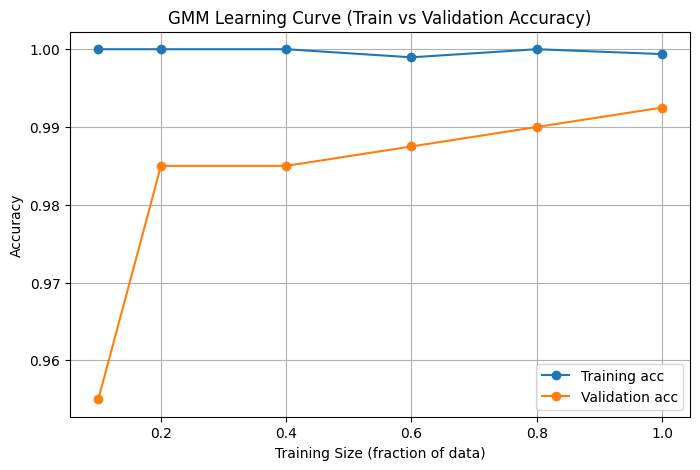

In [250]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_acc_curve, marker='o', label='Training acc')
plt.plot(train_sizes, val_acc_curve, marker='o', label='Validation acc')

plt.xlabel("Training Size (fraction of data)")
plt.ylabel("Accuracy")
plt.title("GMM Learning Curve (Train vs Validation Accuracy)")
plt.legend()
plt.grid(True)
plt.show()


In [238]:
true_labels = []
pred_labels = []

for i, row in test_df.iterrows():
    file_path = row['path']
    true_spk = row['speaker']

    try:
        feats = extract_mfcc_frames(file_path)  # (T, 39)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

    # Average log-likelihood per frame for each speaker model
    scores = {}
    for spk, gmm in speaker_models.items():
        ll = gmm.score(feats)  # average per-frame log-likelihood
        scores[spk] = ll

    # Pick speaker with highest score
    pred_spk = max(scores, key=scores.get)

    true_labels.append(true_spk)
    pred_labels.append(pred_spk)

# Encode as arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

acc = accuracy_score(true_labels, pred_labels)
gmm_acc = acc * 100
print(f"GMM Test Accuracy: {acc*100:.2f}%")

print("\nClassification report:")
print(classification_report(true_labels, pred_labels))




GMM Test Accuracy: 99.25%

Classification report:
                 precision    recall  f1-score   support

   AslakKnutsen       1.00      0.95      0.97        20
         Bahoke       0.95      1.00      0.98        20
       Catbells       1.00      1.00      1.00        18
ColinBeckingham       1.00      1.00      1.00        20
          Coren       1.00      1.00      1.00        20
         DavidL       1.00      1.00      1.00        20
       Dcoetzee       1.00      1.00      1.00        20
         Ertain       1.00      1.00      1.00        22
     FrozenFire       1.00      1.00      1.00        20
   GaylandGGump       1.00      1.00      1.00        20
        Mariane       1.00      1.00      1.00        20
              Q       1.00      1.00      1.00        20
           Rain       1.00      1.00      1.00        20
          Robin       0.95      1.00      0.98        20
        Steltek       1.00      0.95      0.97        20
      akhansson       1.00      1.00 

In [239]:
import numpy as np

# Extract SVM features for TRAIN set
X_train = np.array([extract_mfcc_summary(path) for path in train_df['path']])
y_train = train_df['speaker'].values

# Extract SVM features for TEST set
X_test = np.array([extract_mfcc_summary(path) for path in test_df['path']])
y_test = test_df['speaker'].values

X_train.shape, X_test.shape


((1600, 78), (400, 78))

In [240]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# SVM classifier with RBF kernel
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

# Train
svm_clf.fit(X_train, y_train)

# Predict on TEST set
y_pred = svm_clf.predict(X_test)

# Test accuracy
svm_acc = accuracy_score(y_test, y_pred) * 100
print(f"SVM Test Accuracy: {svm_acc:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



SVM Test Accuracy: 96.75%

Classification Report:
                 precision    recall  f1-score   support

   AslakKnutsen       1.00      0.90      0.95        20
         Bahoke       0.95      0.90      0.92        20
       Catbells       1.00      0.83      0.91        18
ColinBeckingham       0.95      1.00      0.98        20
          Coren       1.00      1.00      1.00        20
         DavidL       1.00      1.00      1.00        20
       Dcoetzee       1.00      1.00      1.00        20
         Ertain       1.00      0.91      0.95        22
     FrozenFire       1.00      1.00      1.00        20
   GaylandGGump       0.91      1.00      0.95        20
        Mariane       0.95      1.00      0.98        20
              Q       1.00      1.00      1.00        20
           Rain       1.00      1.00      1.00        20
          Robin       0.95      0.95      0.95        20
        Steltek       1.00      0.95      0.97        20
      akhansson       0.87      1.00 

In [234]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Linear SVM
linear_svm = LinearSVC(random_state=42, C=1.0)

linear_svm.fit(X_train, y_train)

y_pred_linear = linear_svm.predict(X_test)

linear_acc = accuracy_score(y_test, y_pred_linear) * 100
print(f"Linear SVM Test Accuracy: {linear_acc:.2f}%")

print("\nClassification Report (Linear SVM):")
print(classification_report(y_test, y_pred_linear))


Linear SVM Test Accuracy: 96.50%

Classification Report (Linear SVM):
                 precision    recall  f1-score   support

   AslakKnutsen       0.95      0.95      0.95        20
         Bahoke       1.00      0.85      0.92        20
       Catbells       1.00      1.00      1.00        18
ColinBeckingham       1.00      1.00      1.00        20
          Coren       1.00      1.00      1.00        20
         DavidL       0.91      1.00      0.95        20
       Dcoetzee       0.95      1.00      0.98        20
         Ertain       1.00      0.91      0.95        22
     FrozenFire       0.95      1.00      0.98        20
   GaylandGGump       1.00      1.00      1.00        20
        Mariane       1.00      1.00      1.00        20
              Q       1.00      1.00      1.00        20
           Rain       0.91      1.00      0.95        20
          Robin       1.00      0.90      0.95        20
        Steltek       0.90      0.90      0.90        20
      akhansson  

In [241]:
print("========================================")
print("     Speaker Identification Results      ")
print("========================================")

print(f"GMM (Per-Speaker) Accuracy:      {gmm_acc:.2f}%")
print(f"Linear SVM Accuracy:             {linear_acc:.2f}%")
print(f"RBF SVM Accuracy:                {svm_acc:.2f}%")

print("========================================")


     Speaker Identification Results      
GMM (Per-Speaker) Accuracy:      99.25%
Linear SVM Accuracy:             96.50%
RBF SVM Accuracy:                96.75%


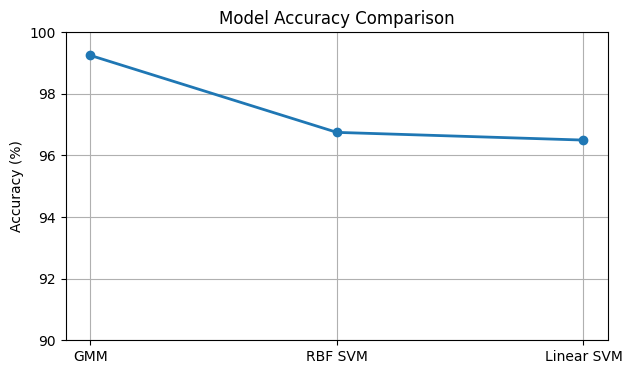

In [253]:
import matplotlib.pyplot as plt

models = ['GMM', 'RBF SVM', 'Linear SVM']
accuracies = [gmm_acc, svm_acc,linear_acc ]

plt.figure(figsize=(7,4))
plt.plot(models, accuracies, marker='o', linewidth=2)
plt.ylim(90, 100)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


In [244]:
# Convert predictions to arrays for statistical tests
gmm_pred = np.array(pred_labels)         # from GMM section
svm_pred = np.array(y_pred)              # RBF SVM predictions
linear_pred = np.array(y_pred_linear)    # Linear SVM predictions

true = np.array(true_labels)             # true speaker labels


In [245]:
from statsmodels.stats.contingency_tables import mcnemar

a = b = c = d = 0

for t, p1, p2 in zip(true, gmm_pred, svm_pred):
    if p1 == t and p2 == t:
        a += 1
    elif p1 == t and p2 != t:
        b += 1
    elif p1 != t and p2 == t:
        c += 1
    else:
        d += 1

table = [[a, b],
         [c, d]]

result = mcnemar(table, exact=False, correction=True)
print("McNemar's Test")
print("Chi-square:", result.statistic)
print("p-value:", result.pvalue)


McNemar's Test
Chi-square: 5.785714285714286
p-value: 0.016156931261181322


In [251]:
import scipy.stats as stats

gmm_correct = (gmm_pred == true).astype(int)
svm_correct = (svm_pred == true).astype(int)

t_stat, p = stats.ttest_rel(gmm_correct, svm_correct)
print("\nPaired t-test (GMM vs RBF SVM)")
print("t =", t_stat)
print("p =", p)



Paired t-test (GMM vs RBF SVM)
t = 2.6934263410283665
p = 0.007370453563091637


In [260]:
def add_gaussian_noise(y, snr_db=20):
    """
    Add Gaussian noise to an audio signal.
    snr_db: signal-to-noise ratio in dB
    """
    rms_signal = np.sqrt(np.mean(y**2))
    snr_linear = 10**(snr_db / 20)
    rms_noise = rms_signal / snr_linear
    noise = np.random.normal(0, rms_noise, y.shape[0])
    return y + noise

In [261]:
new_df = pd.DataFrame(new_rows)
new_csv_path = '/content/drive/MyDrive/extracted_audios/audio_index_noisy.csv'
new_df.to_csv(new_csv_path, index=False)
print("Noisy audios saved and CSV updated at:", new_csv_path)

Noisy audios saved and CSV updated at: /content/drive/MyDrive/extracted_audios/audio_index_noisy.csv


In [262]:
import pandas as pd

# Path to the new CSV
new_csv_path = '/content/drive/MyDrive/extracted_audios/audio_index_noisy.csv'

# Read it
df_noisy = pd.read_csv(new_csv_path)

# Display first few rows
df_noisy.head()


,speaker,path
0,Ertain,/content/drive/MyDrive/noisy_audios/Ertain/b00...
1,azmisov,/content/drive/MyDrive/noisy_audios/azmisov/a0...
2,Robin,/content/drive/MyDrive/noisy_audios/Robin/b035...
3,anonymous,/content/drive/MyDrive/noisy_audios/anonymous/...
4,Bahoke,/content/drive/MyDrive/noisy_audios/Bahoke/b04...


In [273]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

# Macro F1 score (average across all speakers)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 score: {f1:.4f}")

# Detailed classification report per speaker
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)


Accuracy: 96.75%
Macro F1 score: 0.9672
Classification Report:

                 precision    recall  f1-score   support

   AslakKnutsen       1.00      0.90      0.95        20
         Bahoke       0.95      0.90      0.92        20
       Catbells       1.00      0.83      0.91        18
ColinBeckingham       0.95      1.00      0.98        20
          Coren       1.00      1.00      1.00        20
         DavidL       1.00      1.00      1.00        20
       Dcoetzee       1.00      1.00      1.00        20
         Ertain       1.00      0.91      0.95        22
     FrozenFire       1.00      1.00      1.00        20
   GaylandGGump       0.91      1.00      0.95        20
        Mariane       0.95      1.00      0.98        20
              Q       1.00      1.00      1.00        20
           Rain       1.00      1.00      1.00        20
          Robin       0.95      0.95      0.95        20
        Steltek       1.00      0.95      0.97        20
      akhansson       0

In [274]:
from sklearn.mixture import GaussianMixture

# 3A. Collect all frame-level features per speaker
train_features_noisy = {}

for spk in train_df_noisy['speaker'].unique():
    spk_paths = train_df_noisy[train_df_noisy['speaker'] == spk]['path']
    all_feats = []

    for p in spk_paths:
        feats = extract_mfcc_frames(p)   # shape: (n_frames, n_features)
        all_feats.append(feats)

    all_feats = np.vstack(all_feats)
    train_features_noisy[spk] = all_feats

# 3B. Train one GMM per speaker (noisy)
gmm_models_noisy = {}
n_components = 16  # or whatever you used before

for spk, feats in train_features_noisy.items():
    print(f"Training noisy GMM for {spk} with {feats.shape[0]} frames")
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type="diag",
                          random_state=42)
    gmm.fit(feats)
    gmm_models_noisy[spk] = gmm


Training noisy GMM for Ertain with 12519 frames
Training noisy GMM for azmisov with 12833 frames
Training noisy GMM for Robin with 10756 frames
Training noisy GMM for anonymous with 9285 frames
Training noisy GMM for Bahoke with 9849 frames
Training noisy GMM for akiplaner with 19953 frames
Training noisy GMM for Catbells with 11878 frames
Training noisy GMM for GaylandGGump with 16401 frames
Training noisy GMM for AslakKnutsen with 12615 frames
Training noisy GMM for Dcoetzee with 11840 frames
Training noisy GMM for Coren with 12754 frames
Training noisy GMM for DavidL with 17110 frames
Training noisy GMM for FrozenFire with 14255 frames
Training noisy GMM for Steltek with 7883 frames
Training noisy GMM for akhansson with 15816 frames
Training noisy GMM for Q with 13505 frames
Training noisy GMM for ColinBeckingham with 17035 frames
Training noisy GMM for bhart with 12143 frames
Training noisy GMM for Mariane with 13314 frames
Training noisy GMM for Rain with 13329 frames


In [275]:
from sklearn.metrics import accuracy_score, classification_report

gmm_noisy_true = []
gmm_noisy_preds = []

for idx, row in test_df_noisy.iterrows():
    true_spk = row['speaker']
    path = row['path']

    # Extract frame-level MFCC(+delta+delta-delta) features
    feats = extract_mfcc_frames(path)  # shape: (n_frames, n_features)

    # Score each GMM
    scores = {spk: model.score(feats) for spk, model in gmm_models_noisy.items()}
    pred_spk = max(scores, key=scores.get)

    gmm_noisy_true.append(true_spk)
    gmm_noisy_preds.append(pred_spk)

# Overall accuracy
gmm_noisy_accuracy = accuracy_score(gmm_noisy_true, gmm_noisy_preds)
print("Noisy GMM accuracy:", gmm_noisy_accuracy)

# Classification report
print("Classification report (GMM, noisy data):")
print(classification_report(gmm_noisy_true, gmm_noisy_preds))


Noisy GMM accuracy: 0.9725
Classification report (GMM, noisy data):
                 precision    recall  f1-score   support

   AslakKnutsen       1.00      1.00      1.00        20
         Bahoke       0.86      0.90      0.88        20
       Catbells       1.00      0.89      0.94        18
ColinBeckingham       1.00      1.00      1.00        20
          Coren       0.95      1.00      0.98        20
         DavidL       1.00      1.00      1.00        20
       Dcoetzee       1.00      0.95      0.97        20
         Ertain       1.00      1.00      1.00        22
     FrozenFire       1.00      1.00      1.00        20
   GaylandGGump       1.00      1.00      1.00        20
        Mariane       1.00      1.00      1.00        20
              Q       1.00      1.00      1.00        20
           Rain       1.00      1.00      1.00        20
          Robin       0.90      0.95      0.93        20
        Steltek       1.00      1.00      1.00        20
      akhansson    

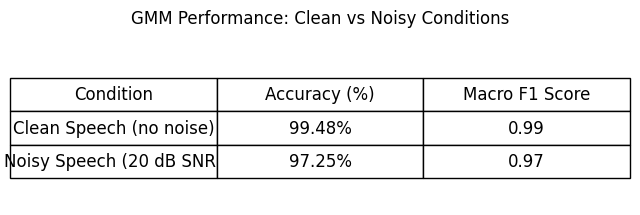

In [276]:
import matplotlib.pyplot as plt

# Replace these with your actual results
clean_acc = 99.48
noisy_acc = 97.25
clean_f1 = 0.99   # update with your real macro F1
noisy_f1 = 0.97   # update with your real macro F1

# Prepare table data
data = [
    ["Clean Speech (no noise)", f"{clean_acc:.2f}%", f"{clean_f1:.2f}"],
    ["Noisy Speech (20 dB SNR)", f"{noisy_acc:.2f}%", f"{noisy_f1:.2f}"],
]

column_labels = ["Condition", "Accuracy (%)", "Macro F1 Score"]

# Create figure
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')  # remove plot axes

# Create table
table = ax.table(
    cellText=data,
    colLabels=column_labels,
    cellLoc='center',
    loc='center'
)

# Styling
table.scale(1, 2)  # make rows taller
table.auto_set_font_size(False)
table.set_fontsize(12)

# Display figure
plt.title("GMM Performance: Clean vs Noisy Conditions", pad=20)
plt.show()
